## Settings

In [2]:
import random
import time
import os
import datetime
import itertools
import math
import sys
from random import randint
import shutil
import gc

In [3]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [4]:
if IN_COLAB:
  COLAB_BASE_DIR = "/content/gdrive/MyDrive/Universidad/VIU/TFM/notebooks/"
  from google.colab import drive
  drive.mount('/content/gdrive/')
  sys.path.append(os.path.join(COLAB_BASE_DIR, 'ConvLSTM'))
  sys.path.append(os.path.join(COLAB_BASE_DIR, 'common'))

Mounted at /content/gdrive/


In [5]:
if IN_COLAB:
  if not os.path.exists("/data/video_prediction_dataset.hdf5"):
    #!gdown 1fYtaFcGKSL8ykJFbewAFsFf9C4aW0DuV
    %cp /content/gdrive/MyDrive/Universidad/VIU/TFM/otros/Data_publication/video_prediction_dataset.hdf5 /content/
    !gdown 1OEqxhm4NrK1NDsQaBxuG22YY3K92SduH
    %mkdir -p /data
    %mv /content/*.hdf5 /data/
    %mv /content/*.png /data/
    %mkdir save

Downloading...
From: https://drive.google.com/uc?id=1OEqxhm4NrK1NDsQaBxuG22YY3K92SduH
To: /content/mask_black_skygptdata.png
100% 5.89k/5.89k [00:00<00:00, 22.8MB/s]


In [6]:
%%capture
%pip install torch torchvision h5py xarray matplotlib netcdf4

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils.data as data
from torch.utils.data import DataLoader
import numpy as np
import h5py
import PIL.Image
from IPython.core import display as idisplay
import matplotlib.pyplot as plt
import xarray as xr

from ConvLSTMmodels import Seq2SeqConvLSTM, RNNConvLSTM
if not IN_COLAB:
  sys.path.append('../common')
import common

In [8]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data process

In [9]:
cwd = os.getcwd()
model_name_rnn = "ConvLSTM_old"
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,'data')
mask_path = os.path.join(data_folder,'mask_black_skygptdata.png')
data_path = os.path.join(data_folder, 'video_prediction_dataset.hdf5')
output_path = os.path.join(cwd, "save", f"{model_name_rnn}.torch")
if IN_COLAB:
  output_path = os.path.join(COLAB_BASE_DIR, "ConvLSTM", f"{model_name_rnn}.torch")

In [10]:
with h5py.File(data_path, 'r') as fds:
    group_names = list(fds.keys())
    print(group_names)

dss = {}
for gname in group_names:
    try:
        dss[gname] = xr.open_dataset(data_path, group=gname)
    except Exception:
        dss[gname] = xr.open_dataset(data_path, group=gname, engine="h5netcdf", phony_dims="sort")

['test', 'trainval']


In [11]:
mask_png = np.array(PIL.Image.open(mask_path).resize((64, 64)).getdata())
# Mask for size 64
print(mask_png.shape)
mask_to_black = (mask_png[:,3] > 127)
not_mask_to_black = (mask_png[:,3] <= 127)
print(mask_to_black.sum()) # alpha = 1 = black visible
print(not_mask_to_black.sum())
print(not_mask_to_black.sum()+mask_to_black.sum())
mask_to_black = mask_to_black.reshape((64, 64))
empty_mask = np.ones((64, 64, 3))
mask_to_black = np.where(np.expand_dims(mask_to_black, 2), empty_mask, empty_mask*0)

(4096, 4)
1418
2678
4096


In [12]:
COMPUTED_MEANS = [0.31083446741104126, 0.2867564558982849, 0.2777233123779297]
COMPUTED_STDS = [0.23008835315704346, 0.2290412336587906, 0.2250392884016037]

In [13]:
transform_t = transforms.Compose([
    transforms.Lambda(lambda x: np.where(mask_to_black, x*0, x)),
    transforms.ToPILImage(),
    #transforms.functional.autocontrast,
    transforms.Resize(64),
    transforms.ToTensor(),
    #transforms.Normalize(mean=COMPUTED_MEANS, std=COMPUTED_STDS),
])
bs = 8

test_dataset = common.VideoDataset(dss['test']['images_log'], dss['test']['images_pred'], transform=transform_t, stack_videos=False, device=device)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

print(f"Number of videos: {len(test_dataset.videos)}.")
print(f"Number of video batches: {len(test_loader)}")
print(f"Size of video batches: {bs}.")

Number of videos: 4467.
Number of video batches: 559
Size of video batches: 8.


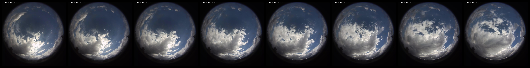

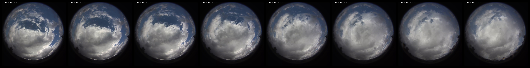

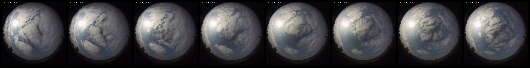

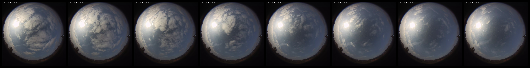

In [88]:
def _show_vid_data(vid_data):
  vid_data = vid_data[::2].flip(dims=(1,))
  torchvision.utils.save_image(vid_data, 'save/real_image.png')
  display(idisplay.Image('save/real_image.png'))

def _show_vid(raw_vid_data):
  vid_data = torch.tensor(raw_vid_data).permute((0, 3, 1, 2))
  vid_data = [transforms.ToTensor()(transforms.ToPILImage()(img)) for img in vid_data]
  vid_data = torch.stack(vid_data)
  _show_vid_data(vid_data)

def show_vid(dss, idx):
  dst = dss['test']
  _show_vid(dst['images_log'][idx*8].data)
  _show_vid(dst['images_pred'][idx*8].data)

show_vid(dss, 310)
show_vid(dss, 229)

In [84]:

bs = 1

test_dataset_pic = common.VideoDataset(dss['test']['images_log'][229*8:311*8:(310-229)*8], dss['test']['images_pred'][229*8:311*8:(310-229)*8], transform=transform_t, stack_videos=False, device=device)
test_loader_pic = DataLoader(test_dataset_pic, batch_size=bs, shuffle=False)

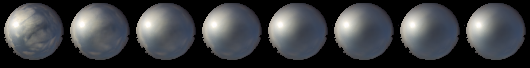

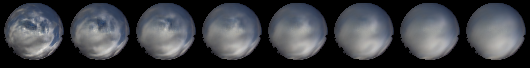

In [89]:
with torch.no_grad():
  clstm.eval()
  for idx, (videos, targets) in enumerate(test_loader_pic):
    outputs = clstm(videos, targets.size(1))
    _show_vid_data(outputs[0])

## Load model

In [14]:
def load_convlstm(path: str, device):
  hidden_dims = [128, 128, 64]
  kernel_size = (3, 3)
  n_layers = 3
  clstm = RNNConvLSTM(hidden_dims, kernel_size, n_layers, device)
  clstm.load_state_dict(torch.load(path, map_location='cpu'))
  return clstm

In [15]:
clstm = load_convlstm(output_path, device)

<ipython-input-14-bfb2c3fd0a32>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clstm.load_state_dict(torch.load(path, map_location='cpu'))


## Evaluate

In [72]:
torch.cuda.empty_cache()
loss_function = nn.MSELoss(reduction='sum')

losses_tsteps = [0 for _ in range(15)]
loss = 0

with torch.no_grad():
  clstm.eval()
  for idx, (videos, targets) in enumerate(test_loader):
    outputs = clstm(videos, targets.size(1))
    for i in range(15):
      lossp = loss_function(outputs[:,i,:,:,:], targets[:,i,:,:,:])
      losses_tsteps[i] += lossp.item()
    if idx %10 == 0:
      print(f"Batch {idx}/{len(test_loader)}")
    lossp = loss_function(outputs, targets)
    loss += lossp.item()
    lossp = None
    outputs = None

KeyboardInterrupt: 

In [ ]:
print(loss)
print(losses_tsteps)

In [ ]:
#loss = 4206968.286834717
#losses_tsteps = [81174.01201295853, 129965.32912874222, 168111.92955970764, 200098.13072633743, 227655.2459821701, 253205.56989192963, 276445.6150188446, 298006.9210538864, 317668.52432346344, 336279.51361846924, 353549.9067745209, 369670.9091415405, 384614.2466697693, 398745.6209163666, 411776.7627182007]
loss = 3262424.7819519043
losses_tsteps = [63981.17190861702, 100664.27593231201, 130647.462079525, 156336.8825044632, 178649.03850269318, 198654.0722875595, 216817.39347553253, 233183.7131357193, 247966.19857692719, 261632.34273910522, 273825.75592136383, 284908.21430397034, 295297.4710216522, 305212.1937980652, 314648.55619621277]

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
n_vidba = 559*8
losses_tsteps = np.array(losses_tsteps)/n_vidba
loss = loss/(15*n_vidba)
print(loss)
print(losses_tsteps)
print(np.mean(losses_tsteps))

In [ ]:
original_losses = [26.4, 36.3, 44, 50, 55.8, 60, 64.1, 67]

In [ ]:
plt.plot(range(1, 16), losses_tsteps, '-o', label='ConvLSTM entrenado')
plt.plot(range(1, 16, 2), original_losses, '-o', label='ConvLSTM objetivo')
plt.xlabel('Time step (min)')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()